In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from melon_clustering import PatternExtractorGraph, ClusterEvaluator, ClusterManager, Loader, reference_clusters_de, CACHE_DIR

dim_reduction_methods = ['LSA', 'PCA', 't-SNE', 'MDS']
clustering_methods = ['KMeans', 'Agglomerative', 'DBSCAN']

# Initialize an empty list to hold all results
results_collection = []

for sigmoid_steepness in [0.2, 0.4, 0.6, 0.8, 1]:
    for overlap_threshold in [0.2, 0.4, 0.6, 0.8, 1]:
        for n_sentences in [5, 50, 500, 5000, 10000]:
            for ref_word, reference_clusters in reference_clusters_de.items():
                additional_sentences_dict = Loader.load_sentences_from_word(ref_word, 'de', n_sentences=n_sentences)
                evaluator = ClusterEvaluator(reference_clusters=reference_clusters)
                sentences_dict_ref = evaluator.add_reference_sentences(reference_clusters)
                sentences_dict_db = evaluator.add_additional_sentences(additional_sentences_dict)

                extractor = PatternExtractorGraph()
                extractor.initialize(evaluator.sentences_dict, overlap_threshold=overlap_threshold)
                extractor.initialize_node_embeddings()
                extractor.print_trees()

                embeddings, sentences_list = extractor.get_all_sentence_embeddings(evaluator.sentences_dict, steepness=sigmoid_steepness)

                vectors_reference = evaluator.isolate_reference_embeddings(embeddings, num_additional_sentences=len(sentences_dict_db['krass']))
                reference_sentence_ids = sorted(evaluator.reference_sentence_ids)
                reference_sentence_paths = [(sid, evaluator.sentence_id_to_original[sid]) for sid in reference_sentence_ids]

                clustering_results = evaluator.run_all_configurations(
                    vectors=vectors_reference,
                    dim_methods=dim_reduction_methods,
                    cluster_methods=clustering_methods,
                    sentence_paths=reference_sentence_paths,
                    plot_seaborn=False,
                    plot_plt=False,
                    annotate_plt=True
                )

                results_df = evaluator.evaluate_multiple_configurations(clustering_results, ref_word, plot=False,
                                                                        overlap_threshold=str(overlap_threshold),
                                                                        n_sentences=str(n_sentences),
                                                                        sigmoid_steepness=str(sigmoid_steepness))

                # Add additional information to each result and store in a list
                for index, row in results_df.iterrows():
                    row_data = {
                        'Ref Word': ref_word,
                        'Overlap Threshold': overlap_threshold,
                        'Num Sentences': n_sentences,
                        'Sigmoid Steepness': sigmoid_steepness,
                        'Dimensionality Reduction': row['Dimensionality Reduction'],
                        'Clustering Method': row['Clustering Method'],
                        'Average Jaccard Similarity': row['Average Jaccard Similarity']
                    }
                    results_collection.append(row_data)

df = pd.DataFrame(results_collection)
df.to_csv(CACHE_DIR / 'clustering_results.csv', index=False)
df.head()


Preceding Tree (before <ROOT>):
<ROOT> (count: 0, id: 0)
  <START> (count: 3, id: 2)
  eine (count: 2, id: 21)
    war (count: 1, id: 22)
      Das (count: 1, id: 23)
        <START> (count: 1, id: 24)
    hatte (count: 1, id: 28)
      Er (count: 1, id: 29)
        <START> (count: 1, id: 30)
  war (count: 3, id: 34)
    Party (count: 1, id: 35)
      Die (count: 1, id: 36)
        <START> (count: 1, id: 37)
    Sie (count: 1, id: 48)
      <START> (count: 1, id: 49)
    Vortrag (count: 1, id: 55)
      Der (count: 1, id: 56)
        <START> (count: 1, id: 57)
  das (count: 1, id: 41)
    hat (count: 1, id: 42)
      Er (count: 1, id: 43)
        <START> (count: 1, id: 44)
  ist (count: 1, id: 60)
    Unterschied (count: 1, id: 61)
      der (count: 1, id: 62)
        Also (count: 1, id: 63)
          <START> (count: 1, id: 64)
  richtig (count: 1, id: 73)
    schon (count: 1, id: 74)
      Ist (count: 1, id: 75)
        so (count: 1, id: 76)
          und (count: 1, id: 77)
          

In [ ]:
grouped_df = df.groupby(['Overlap Threshold', 'Num Sentences', 'Sigmoid Steepness'])['Average Jaccard Similarity'].agg(['mean', 'var']).reset_index()
method_analysis_df = df.groupby(['Dimensionality Reduction', 'Clustering Method'])['Average Jaccard Similarity'].agg(['mean', 'var']).reset_index()
method_analysis_df = method_analysis_df.sort_values(by=['mean', 'var'], ascending=[False, True])

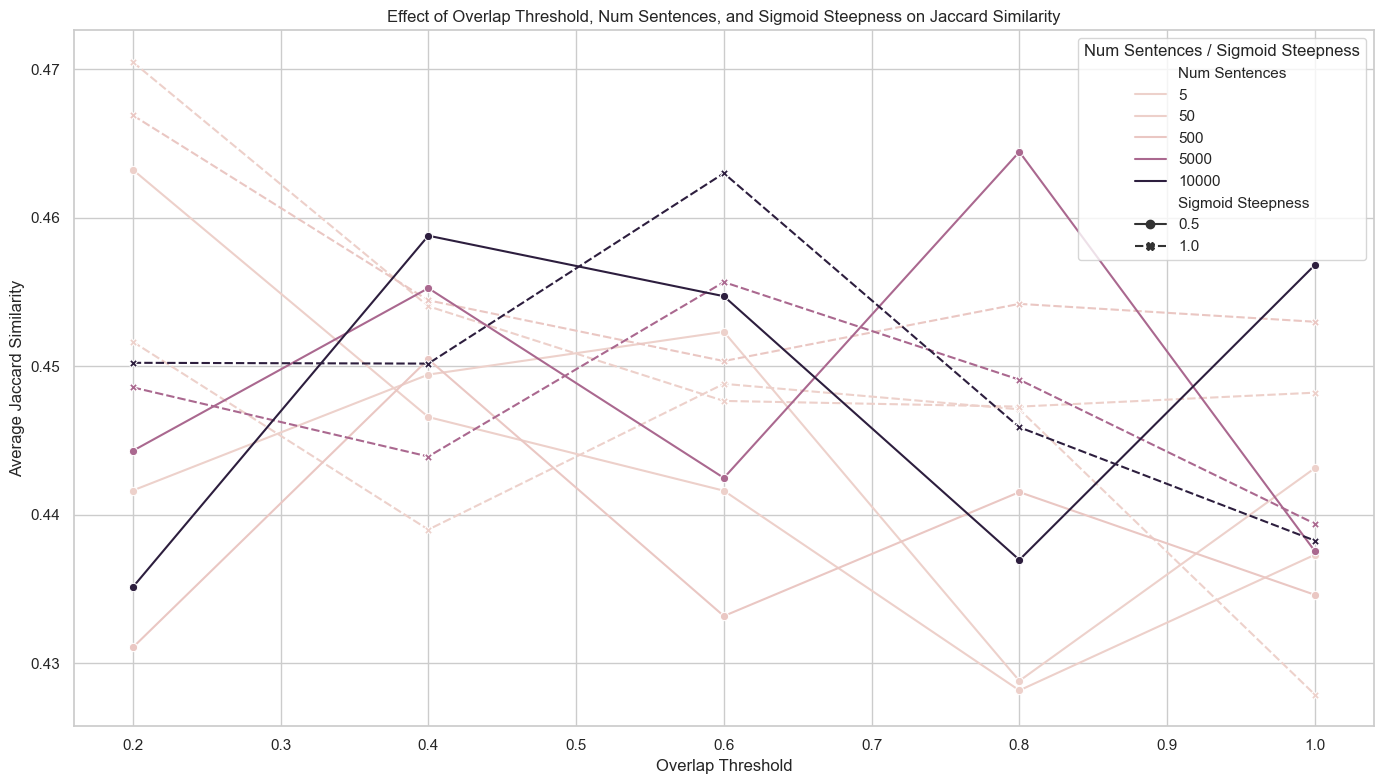

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the style for seaborn plots
sns.set(style="whitegrid")

# 1. Line plot showing how Jaccard Similarity changes with Overlap Threshold, Num Sentences, and Sigmoid Steepness
plt.figure(figsize=(14, 8))
sns.lineplot(x='Overlap Threshold', y='mean', hue='Num Sentences', style='Sigmoid Steepness', data=grouped_df, markers=True)
plt.title('Effect of Overlap Threshold, Num Sentences, and Sigmoid Steepness on Jaccard Similarity')
plt.ylabel('Average Jaccard Similarity')
plt.xlabel('Overlap Threshold')
plt.legend(title='Num Sentences / Sigmoid Steepness')
plt.tight_layout()
plt.show()


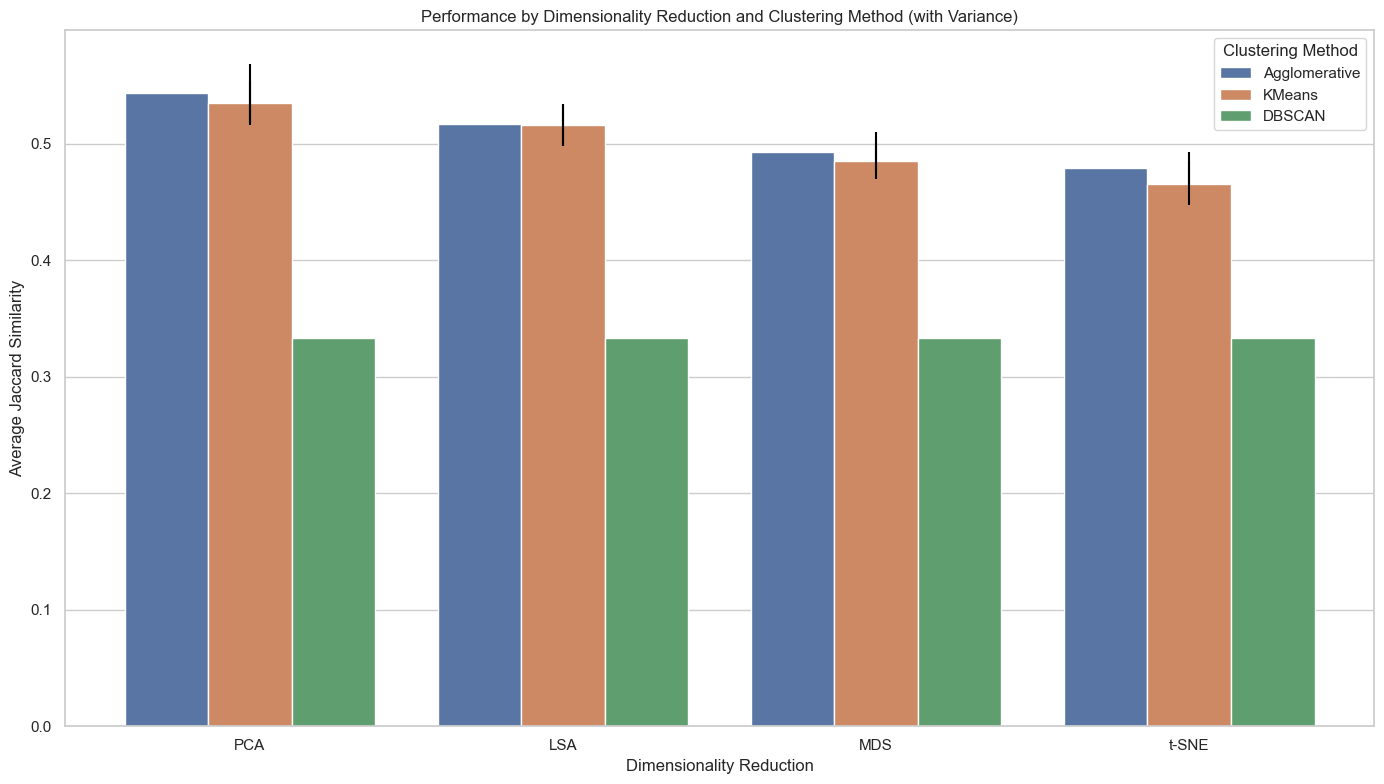

In [ ]:
# 3. Bar plot with error bars showing mean and variance for each method
plt.figure(figsize=(14, 8))
sns.barplot(x='Dimensionality Reduction', y='mean', hue='Clustering Method', data=method_analysis_df, ci=None, capsize=.2)
plt.errorbar(x=method_analysis_df['Dimensionality Reduction'], y=method_analysis_df['mean'], yerr=method_analysis_df['var'], fmt='none', c='black')
plt.title('Performance by Dimensionality Reduction and Clustering Method (with Variance)')
plt.ylabel('Average Jaccard Similarity')
plt.xlabel('Dimensionality Reduction')
plt.tight_layout()
plt.show()



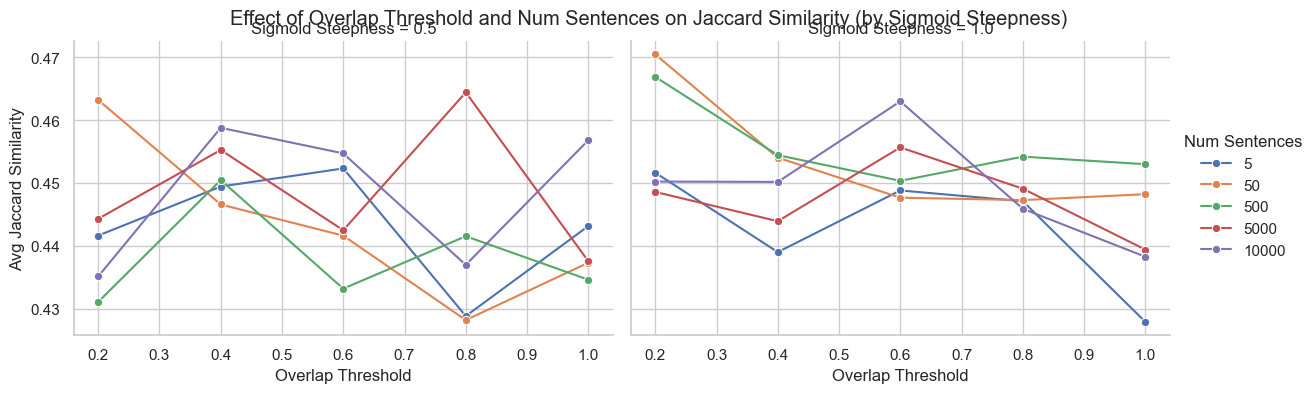

In [ ]:
# 4. FacetGrid for analyzing the effect of multiple parameters
g = sns.FacetGrid(grouped_df, col="Sigmoid Steepness", hue="Num Sentences", height=4, aspect=1.5)
g.map(sns.lineplot, "Overlap Threshold", "mean", marker="o")
g.add_legend()
g.set_axis_labels("Overlap Threshold", "Avg Jaccard Similarity")
g.set_titles("Sigmoid Steepness = {col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Effect of Overlap Threshold and Num Sentences on Jaccard Similarity (by Sigmoid Steepness)')
plt.show()
